# Cross-entropy kernel fit

In [88]:
import numpy as np
import jax.numpy as jnp
import jax
from typing import Callable, Tuple, Dict, Any, Optional
import sys
from pathlib import Path
from kl_decomposition import rectangle_rule, gauss_legendre_rule_multilevel

# Enable 64-bit (double) precision in JAX
jax.config.update("jax_enable_x64", True)

In [89]:
def cross_entropy(
    user_fn: Callable[[np.ndarray], Tuple[np.ndarray, np.ndarray, Dict[str, Any]]],
    initial_mean: np.ndarray,
    initial_std: np.ndarray,
    pop_size: int = 100,
    elite_frac: float = 0.2,
    alpha_mean: float = 0.7,
    alpha_std: float = 0.7,
    n_iters: int = 100,
    random_state: Optional[int] = None,
    verbose: bool = False,
    tol_std: float = 1e-6,
    tol_g: float = 1e-6
) -> Tuple[np.ndarray, float, Dict[str, Any]]:
    """
    Cross-Entropy Method with independent Gaussian distribution and stopping criteria.

    Args:
        user_fn: function taking samples (shape Nxd) and returning
            (updated_samples, scores, info_dict)
        initial_mean: initial mean vector (d,)
        initial_std: initial std deviation vector (d,)
        pop_size: number of samples per iteration
        elite_frac: fraction of samples selected as elites
        alpha_mean: learning rate for mean update
        alpha_std: learning rate for std update
        n_iters: maximum number of iterations
        random_state: RNG seed for reproducibility
        verbose: print debug info each iteration
        tol_std: stop if max(std) <= tol_std
        tol_g: stop if info_dict['normg'] <= tol_g

    Returns:
        best_sample: best found sample (d,)
        best_score: best objective value
        info: dict with:
            'iter': iteration index at stop
            'best_score_history': list of best_score after each iteration
            'max_std_history': list of max_std after each iteration
    """
    rng = np.random.RandomState(random_state)
    mean = np.array(initial_mean, dtype=float)
    std = np.array(initial_std, dtype=float)
    n_elite = max(1, int(np.ceil(pop_size * elite_frac)))
    best_sample: Optional[np.ndarray] = None
    best_score = np.inf

    # history lists
    best_score_history: list = []
    max_std_history: list = []

    for iteration in range(n_iters):
        samples = rng.randn(pop_size, mean.size) * std + mean
        samples, scores, info_dict = user_fn(samples)
        idx = int(np.argmin(scores))
        # update best if improved
        if scores[idx] < best_score:
            best_score = float(scores[idx])
            best_sample = samples[idx]
        # select elites and update distribution
        elite = samples[np.argsort(scores)[:n_elite]]
        elite_mean = elite.mean(axis=0)
        elite_std = elite.std(axis=0, ddof=0)
        mean = alpha_mean * elite_mean + (1 - alpha_mean) * mean
        std = alpha_std * elite_std + (1 - alpha_std) * std
        # record history
        max_std = float(np.max(std))
        best_score_history.append(best_score)
        max_std_history.append(max_std)
        # debug print
        if verbose:
            print(f"Iter {iteration}: best_score={best_score}, max_std={max_std}, info={info_dict}")
        # stopping criteria
        if max_std <= tol_std:
            break
        if info_dict.get('normg', np.inf) <= tol_g:
            break

    info = {
        'iter': iteration,
        'best_score_history': best_score_history,
        'max_std_history': max_std_history
    }
    return best_sample, best_score, info

In [325]:
# setup squared exponential approximation
# x, w = rectangle_rule(0.0, 2.0, 500)
x, w = gauss_legendre_rule_multilevel(0.0, 1.0, 100, L=5, ratio=0.2)

target = np.exp(-x)
# target = np.cos(np.pi/2 * x)  # use cosine for a more complex target

# Convert to JAX arrays with float64 dtype
x_j = jnp.array(x, dtype=jnp.float64)
w_j = jnp.array(w, dtype=jnp.float64)
target_j = jnp.array(target, dtype=jnp.float64)


def obj_jax(p):
    # p is already float64
    n_param = p.shape[0] // 2
    a = p[:n_param]
    b = jnp.exp(p[n_param:])
    # compute prediction and weighted RMS error
    pred = jnp.sum(a[:, None] * jnp.exp(-b[:, None] * x_j[None, :] ** 2), axis=0)
    diff = pred - target_j
    return jnp.sqrt(jnp.sum(w_j * diff ** 2))


# gradients and Hessians in double precision
grad_jax = jax.jit(jax.grad(obj_jax))
hess_jax = jax.jit(jax.hessian(obj_jax))
obj_jax_jit = jax.jit(obj_jax)


def obj(p):
    # ensure NumPy→JAX conversion to float64
    return float(obj_jax_jit(jnp.array(p, dtype=jnp.float64)))


def grad(p):
    return np.array(grad_jax(jnp.array(p, dtype=jnp.float64)))


def hess(p):
    return np.array(hess_jax(jnp.array(p, dtype=jnp.float64)))

In [121]:
import numpy as np
from typing import Callable, Tuple, List, Dict, Any


def adam_minimize(
    f: Callable[[np.ndarray], float],
    g: Callable[[np.ndarray], np.ndarray],
    x0: np.ndarray,
    *,
    lr: float = 1e-2,
    beta1: float = 0.9,
    beta2: float = 0.999,
    eps: float = 1e-8,
    max_iter: int = 10_000,
    tol: float = 1e-8,
    verbose: bool = False,
    print_every: int = 100,
    # NEW adaptive-LR knobs
    patience: int = 20,
    decay_factor: float = 0.5,
    callback: Callable[[Dict[str, Any]], None] | None = None,
) -> Tuple[np.ndarray, float, List[float]]:
    """
    Adam minimiser with optional adaptive learning-rate decay.

    When the gradient-norm has not improved for `patience` consecutive
    steps, the current learning rate is multiplied by `decay_factor`.
    """
    x = np.asarray(x0, dtype=float)
    m = np.zeros_like(x)
    v = np.zeros_like(x)
    f_hist: List[float] = []

    beta1_t = beta2_t = 1.0
    best_grad_norm = np.inf
    wait = 0  # iterations since last grad improvement

    if verbose:
        hdr = " iter |     f         |grad|      lr   "
        print(hdr + "-" * (2 * len(hdr)))

    for t in range(1, max_iter + 1):
        grad = g(x)
        grad_norm = np.linalg.norm(grad)

        # adaptive-LR bookkeeping
        improved = grad_norm < best_grad_norm - 1e-12  # tiny margin
        if improved:
            best_grad_norm = grad_norm
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                lr *= decay_factor
                wait = 0  # reset counter
                if verbose:
                    print(f"{t:6d} | lr decayed → {lr:g}")

        # record objective & early stop
        f_val = f(x)
        f_hist.append(f_val)
        if grad_norm < tol:
            if verbose:
                print(f"{t:6d} | {f_val:11.4e} | {grad_norm:9.2e} | {lr:8g}  (converged)")
            break

        # moment updates
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad * grad)
        beta1_t *= beta1
        beta2_t *= beta2
        m_hat = m / (1 - beta1_t)
        v_hat = v / (1 - beta2_t)

        # parameter step
        x -= lr * m_hat / (np.sqrt(v_hat) + eps)

        if verbose and (t == 1 or t % print_every == 0):
            print(f"{t:6d} | {f_val:11.4e} | {grad_norm:9.2e} | {lr:8g}")

        if callback is not None:
            callback(
                dict(iter=t, x=x, f=f_val, grad=grad, grad_norm=grad_norm, lr=lr)
            )

    return x, f_hist[-1], f_hist

In [301]:
import numpy as np
def golden_section_search(f, a=0.0, b=1.0, tol=1e-6, max_iter=100):
    """
    Golden-section search to find the minimum of a unimodal function f on [a, b].

    Parameters
    ----------
    f : callable
        The objective function to minimize.
    a : float
        Left endpoint of the initial interval.
    b : float
        Right endpoint of the initial interval.
    tol : float
        Tolerance for the interval width (stopping criterion).
    max_iter : int
        Maximum number of iterations.

    Returns
    -------
    x_min : float
        Estimated position of the minimum.
    f_min : float
        Value of f at x_min.
    """
    # Golden ratio constant
    phi = (np.sqrt(5.0) - 1) / 2

    # Initialize interior points
    c = b - phi * (b - a)
    d = a + phi * (b - a)
    f_c = f(c)
    f_d = f(d)

    for _ in range(max_iter):
        if abs(b - a) < tol:
            break

        if f_c < f_d:
            b, d, f_d = d, c, f_c
            c = b - phi * (b - a)
            f_c = f(c)
        else:
            a, c, f_c = c, d, f_d
            d = a + phi * (b - a)
            f_d = f(d)

    # Choose the best of the final points
    if f_c < f_d:
        x_min, f_min = c, f_c
    else:
        x_min, f_min = d, f_d
    # print(f"Iterations: {_ + 1}")
    return x_min, f_min


def newton(f, grad, hess, x0,
                                   tol_grad=1e-6,
                                   tol_step=1e-8,
                                   stall_iter=5,
                                   max_iter=100,
                                   ls_bounds=(-1.0, 1.0),
                                   verbose=False):
    """
    Newton's method with backtracking line search and fallback to gradient descent.

    Parameters
    ----------
    f : callable
        Objective function f(x).
    grad : callable
        Gradient of f: grad(x).
    hess : callable
        Hessian of f: hess(x).
    x0 : ndarray
        Initial guess.
    tol_grad : float, optional
        Tolerance for gradient norm.
    tol_step : float, optional
        Tolerance for step size norm for stall criterion.
    stall_iter : int, optional
        Number of consecutive small steps to trigger stop.
    max_iter : int, optional
        Maximum number of iterations.
    ls_bounds : (float, float), optional
        Initial interval for line search.

    Returns
    -------
    x : ndarray
        Estimated minimizer.
    grad_norm : float
        Norm of gradient at the solution.
    f_history : list of float
        History of f values.
    grad_norm_history : list of float
        History of gradient norms.
    """
    x = x0.astype(float)
    f_history = []
    grad_norm_history = []
    fx = f(x)

    stall_count = 0
    trust = 1e-3 * np.eye(len(x))  # trust region to ensure positive definiteness
    last_dir_norm = 1.0  # initial step size for steepest descent fallback

    for k in range(max_iter):
        gx = grad(x)
        grad_norm = np.linalg.norm(gx)

        f_history.append(fx)
        grad_norm_history.append(grad_norm)

        # Check gradient convergence
        if grad_norm < tol_grad:
            break

        # Try Newton step
        try:
            Hx = hess(x)
            p = -np.linalg.solve(Hx + trust, gx)
            trust /= 2
            # ensure descent direction
            if np.dot(p, gx) >= 0:
                raise np.linalg.LinAlgError
            last_dir_norm = np.linalg.norm(p)
        except np.linalg.LinAlgError:
            # fallback to steepest descent
            # print("Hessian not positive definite, using gradient descent")
            p = -gx
            trust *= 10
        # Backtracking line search
        alpha, fx = golden_section_search(
            lambda alpha: f(x + alpha * p),
            a=ls_bounds[0], b=ls_bounds[1], tol=1e-12, max_iter=10000
        )

        # Update
        x_new = x + alpha * p
        step_norm = np.linalg.norm(x_new - x)
        x = x_new

        # Stall criterion
        if step_norm < tol_step:
            stall_count += 1
            if stall_count >= stall_iter:
                break
        else:
            stall_count = 0

        # print debug info
        if verbose:
            print(f"Iter {k}: f={fx:.6e}, grad_norm={grad_norm:.6e}, step_norm={step_norm:.6e}, alpha={alpha:.6f}")

    return x, grad_norm, f_history, grad_norm_history

In [262]:
import numpy as np

from scipy.optimize import nnls


def optimal_a(d: np.ndarray,
              w: np.ndarray,
              target: np.ndarray,
              b: np.ndarray) -> np.ndarray:
    """
    Solve for a >= 0 minimizing
        sum_j w[j] * (sum_k a[k] * exp(-b[k] * d[j]**2) - target[j])**2

    Parameters
    ----------
    d : (J,) array
        Sample points x_j.
    w : (J,) array
        Quadrature weights.
    target : (J,) array
        Target values at each d[j].
    b : (K,) array
        Exponents b_k.

    Returns
    -------
    a : (K,) array
        Non-negative coefficient vector minimizing the weighted LS error.
    """
    # Build design matrix Φ[j,k] = exp(-b[k] * d[j]**2)
    # Note: np.outer(d**2, b) yields shape (J, K)
    Phi = np.exp(-np.outer(d**2, b))     # shape (J, K)

    # Incorporate weights by scaling rows
    W_sqrt = np.sqrt(w)                  # shape (J,)
    Phi_w = Phi * W_sqrt[:, None]        # shape (J, K)
    y_w = target * W_sqrt              # shape (J,)

    a, _ = nnls(Phi_w, y_w)

    return a

def optimal_a_allow_negative(d: np.ndarray,
                                  w: np.ndarray,
                                  target: np.ndarray,
                                  b: np.ndarray) -> np.ndarray:
    """
    Solve for a minimizing the weighted LS error without non-negativity constraint.

    Parameters
    ----------
    d : (J,) array
        Sample points x_j.
    w : (J,) array
        Quadrature weights.
    target : (J,) array
        Target values at each d[j].
    b : (K,) array
        Exponents b_k.

    Returns
    -------
    a : (K,) array
        Coefficient vector minimizing the weighted LS error.
    """
    # Build design matrix Φ[j,k] = exp(-b[k] * d[j]**2)
    Phi = np.exp(-np.outer(d**2, b))     # shape (J, K)

    # Incorporate weights by scaling rows
    W_sqrt = np.sqrt(w)                  # shape (J,)
    Phi_w = Phi * W_sqrt[:, None]        # shape (J, K)
    y_w = target * W_sqrt              # shape (J,)

    a = np.linalg.lstsq(Phi_w, y_w, rcond=None)[0]

    return a

In [326]:
# --- synthetic data ---------------------------------------------------
n_terms = 6               # number of (a_i, b_i) pairs
N       = 500               # data points


b = np.linspace(-1.8, 6, n_terms)
# b = np.array([ -1.00002599e+00, -9.96655417e-01, -9.93284359e-01, -9.89912770e-01])
a = optimal_a(x, w, target, np.exp(b))
print("Optimal a:", a)

means = np.concatenate((a, b))  # initial guess in log-space

# --- optimiser call ---------------------------------------------------
x_vals, grad_norm, f_history, grad_norm_history = newton(
    f=obj,
    grad=grad,
    hess=hess,
    x0=means,
    tol_grad=1e-9,
    tol_step=1e-8,
    stall_iter=500,
    max_iter=3000,
    ls_bounds=(-0.0, 1.0),
    verbose=True
)

print("Optimised parameters:", x_vals)
print("Final gradient norm:", grad_norm)
print("Final objective value:", f_history[-1])

Optimal a: [0.23081915 0.36803268 0.20837827 0.10717386 0.04009758 0.03580928]
Iter 0: f=6.572477e-04, grad_norm=8.022923e-04, step_norm=3.311039e-01, alpha=0.460858
Iter 1: f=4.956173e-04, grad_norm=3.564770e-01, step_norm=3.630612e-01, alpha=0.871282
Iter 2: f=4.920709e-04, grad_norm=1.016726e-01, step_norm=6.985909e-02, alpha=0.083037
Iter 3: f=4.772391e-04, grad_norm=2.800447e-02, step_norm=1.167905e-01, alpha=0.059077
Iter 4: f=4.588053e-04, grad_norm=1.052986e-01, step_norm=1.397980e-01, alpha=0.276915
Iter 5: f=4.348162e-04, grad_norm=7.503877e-02, step_norm=1.906138e-01, alpha=0.412232
Iter 6: f=4.043956e-04, grad_norm=2.419416e-01, step_norm=2.378978e-01, alpha=1.000000
Iter 7: f=3.905795e-04, grad_norm=1.417350e-01, step_norm=1.057770e-01, alpha=0.400132
Iter 8: f=3.676924e-04, grad_norm=2.527081e-01, step_norm=1.373227e-01, alpha=1.000000
Iter 9: f=3.537194e-04, grad_norm=1.417535e-01, step_norm=1.400254e-01, alpha=0.718132
Iter 10: f=3.378851e-04, grad_norm=2.424704e-01, st

In [360]:
# --- synthetic data ---------------------------------------------------
from scipy.optimize import minimize
n_terms = 18               # number of (a_i, b_i) pairs
N = 500               # data points


# b = np.linspace(-1.8, 21, n_terms)
b = all_b[-5] + np.random.randn(n_terms) * 0.3
a = optimal_a(x, w, target, np.exp(b))
print("Optimal a:", a)

means = np.concatenate((a, b))  # initial guess in log-space

# --- optimiser call ---------------------------------------------------

# Replace this block:
# x_vals, grad_norm, f_history, grad_norm_history = newton(...)
# --- call minimise with tighter termination and full second order info ----
res = minimize(
    fun=obj,
    x0=means,
    jac=grad,          # your analytic gradient
    hess=hess,         # <- supply analytic Hessian if you have it!
    method='trust-exact',
    tol=1e-12,         # overall objective tolerance
    options={
        'gtol': 1e-8,   # gradient-norm tolerance
        'maxiter': 100_000,
        'verbose': 3        # print per-iter diagnostics
    }
)


x_vals = res.x
grad_norm = np.linalg.norm(res.jac)
f_history = [res.fun]  # L-BFGS-B doesn't return full history by default
grad_norm_history = [grad_norm]

print("Optimised parameters:", x_vals)
print("Final gradient norm:", grad_norm)
print("Final objective value:", res.fun)
print("Exit status code:", res.status)

Optimal a: [4.00038433e-01 2.51601666e-01 2.04235350e-01 4.41021566e-03
 8.10774634e-02 0.00000000e+00 3.32424096e-04 3.29688190e-02
 6.91024490e-03 0.00000000e+00 1.13965748e-02 9.25208214e-04
 3.94914786e-03 6.46771528e-04 8.72371453e-04 2.93362791e-04
 2.54745826e-04 6.94042698e-05]


/usr/lib/python3.13/site-packages/scipy/optimize/_minimize.py:766: OptimizeWarning: Unknown solver options: verbose
  res = _minimize_trustregion_exact(fun, x0, args, jac, hess,


Optimised parameters: [ 4.48273743e-01  2.58726010e-01  1.10499599e-01  5.96410897e-02
  3.80813487e-02  2.63254927e-02  1.86203909e-02  1.31412728e-02
  9.16618081e-03  4.23696262e-03  6.29195469e-03  2.78909474e-03
  1.78652612e-03  1.10637296e-03  6.56181940e-04  3.67162743e-04
  1.88820642e-04  8.56629440e-05 -1.13012262e+00  5.84760357e-01
  1.75593898e+00  2.63555036e+00  3.40409536e+00  4.14707200e+00
  4.90194585e+00  5.68477087e+00  6.50418582e+00  8.28267764e+00
  7.36740528e+00  9.26074091e+00  1.03164794e+01  1.14717181e+01
  1.27608437e+01  1.42440310e+01  1.60464677e+01  1.85435666e+01]
Final gradient norm: 2.448136581116842e-10
Final objective value: 1.1917640037216353e-07
Exit status code: 0


In [361]:
res

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 1.1917640037216353e-07
       x: [ 4.483e-01  2.587e-01 ...  1.605e+01  1.854e+01]
     nit: 1206
     jac: [-1.850e-10 -1.256e-10 ...  7.919e-18  1.026e-18]
    nfev: 1205
    njev: 860
    nhev: 1205
    hess: [[ 6.887e+06  4.908e+06 ... -2.301e-01 -2.995e-02]
           [ 4.908e+06  3.896e+06 ... -2.301e-01 -2.995e-02]
           ...
           [-2.301e-01 -2.301e-01 ...  1.142e-05  5.731e-07]
           [-2.995e-02 -2.995e-02 ...  5.731e-07  6.166e-07]]

In [271]:
b = np.array([-1.10046159, - 1.0126106,    -0.93360479,   -0.92744446])
optimal_a_allow_negative(x, w, target, np.exp(b))

array([-150.77326491,  269.51678081,  -27.25272604,  -90.49079538])

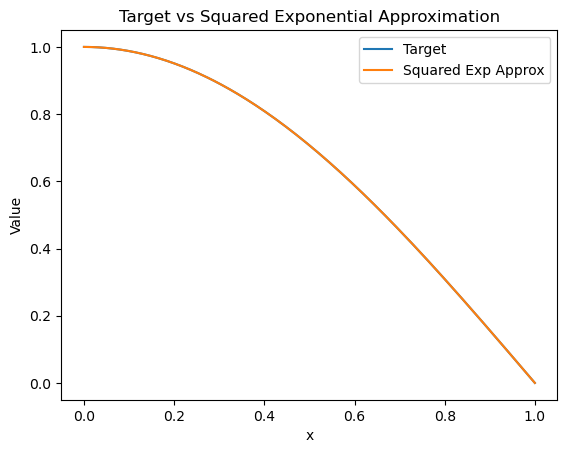

In [281]:
import matplotlib.pyplot as plt

# Number of terms for the approximation
n_terms = x_vals.size // 2

# Extract a and b from x_opt
a = x_vals[:n_terms]
b = np.exp(x_vals[n_terms:])

# Compute the squared exponential approximation
approx = np.sum(a[:, None] * np.exp(-b[:, None] * x**2), axis=0)

# Plot target and approximation
plt.plot(x, target, label='Target')
plt.plot(x, approx, label='Squared Exp Approx')
plt.xlabel('x')
plt.ylabel('Value')
plt.legend()
plt.title('Target vs Squared Exponential Approximation')
plt.show()

In [ ]:
import numpy as np


def interp_extrap_linear_mid(b_old, n_terms, domain=(0.0, 1.0)):
    """
    Like interp_extrap_linear, but assumes *b_old* samples are taken at the
    **mid‑points** of *m* equal sub-intervals spanning *domain*.

        ┌─┬─┬─┬─┐
        │•│•│•│•│   • = sample positions (midpoints)
        └─┴─┴─┴─┘

    Parameters
    ----------
    b_old : 1‑D numpy array
        Original samples (length m).
    n_terms : int
        Desired length of the output array.
    domain : tuple(float, float), optional
        The (start, end) of the x‑axis for *b_old* and *b_new*.

    Returns
    -------
    b_new : 1‑D numpy array
        Resampled array of length *n_terms* with linear interpolation and
        edge‑extrapolation based on the first/last segment slopes.
    """
    m = len(b_old)
    if m < 2:
        raise ValueError("b_old must contain at least two points.")

    tmp_x_bounds = np.linspace(domain[0], domain[1], m + 1)
    x_old = (tmp_x_bounds[:-1] + tmp_x_bounds[1:]) / 2  # mid-points
    tmp_x_bounds = np.linspace(domain[0], domain[1], n_terms + 1)
    x_new = (tmp_x_bounds[:-1] + tmp_x_bounds[1:]) / 2  # mid-points

    # Interpolate within the convex hull of x_old
    b_new = np.interp(x_new, x_old, b_old)

    # Linear extrapolation on the left
    slope_left = (b_old[1] - b_old[0]) / (x_old[1] - x_old[0])
    mask_left = x_new < x_old[0]
    if np.any(mask_left):
        b_new[mask_left] = b_old[0] + slope_left * (x_new[mask_left] - x_old[0])

    # Linear extrapolation on the right
    slope_right = (b_old[-1] - b_old[-2]) / (x_old[-1] - x_old[-2])
    mask_right = x_new > x_old[-1]
    if np.any(mask_right):
        b_new[mask_right] = b_old[-1] + slope_right * (x_new[mask_right] - x_old[-1])

    return b_new

In [210]:
aa = np.linspace(0.0, 1.0, 10, endpoint=True)
(aa[1:] + aa[:-1])/2  # midpoints

array([0.05555556, 0.16666667, 0.27777778, 0.38888889, 0.5       ,
       0.61111111, 0.72222222, 0.83333333, 0.94444444])

In [317]:
b_old = x_vals[n_terms:]
# --- synthetic data ---------------------------------------------------
n_terms = 2          # number of (a_i, b_i) pairs
N = 500               # data points


b = interp_extrap_linear_mid(b_old, n_terms)
print(b)
a = optimal_a(x, w, target, np.exp(b))
print("Optimal a:", a)

means = np.concatenate((a, b))  # initial guess in log-space

# --- optimiser call ---------------------------------------------------
x_vals, grad_norm, f_history, grad_norm_history = newton(
    f=obj,
    grad=grad,
    hess=hess,
    x0=means,
    tol_grad=1e-9,
    tol_step=1e-8,
    stall_iter=500,
    max_iter=10000,
    ls_bounds=(-0.0, 2.5),
    verbose=True
)

print("Optimised parameters:", x_vals)
print("Final gradient norm:", grad_norm)
print("Final objective value:", f_history[-1])

[ 3.84134397 12.74651462]
Optimal a: [1.30450695 0.        ]
Iter 0: f=5.152989e-01, grad_norm=6.261487e-02, step_norm=1.565372e-01, alpha=2.500000
Iter 1: f=5.036129e-01, grad_norm=6.710549e-02, step_norm=1.677637e-01, alpha=2.500000
Iter 2: f=4.900201e-01, grad_norm=7.227473e-02, step_norm=1.806868e-01, alpha=2.500000
Iter 3: f=2.192459e-01, grad_norm=7.825759e-02, step_norm=2.159198e+00, alpha=2.500000
Iter 4: f=5.597605e-02, grad_norm=2.198531e-01, step_norm=1.065644e+00, alpha=0.224573
Iter 5: f=4.851900e-02, grad_norm=3.229937e-01, step_norm=1.197217e-01, alpha=0.776210
Iter 6: f=4.830542e-02, grad_norm=1.933051e-02, step_norm=1.148542e-01, alpha=1.467220
Iter 7: f=4.828710e-02, grad_norm=9.308241e-03, step_norm=4.550522e-02, alpha=1.433791
Iter 8: f=4.825413e-02, grad_norm=4.006364e-03, step_norm=1.481862e-01, alpha=2.500000
Iter 9: f=4.817102e-02, grad_norm=6.020082e-03, step_norm=3.305144e-01, alpha=2.500000
Iter 10: f=4.787659e-02, grad_norm=9.134867e-03, step_norm=8.514950e-

In [ ]:
all_a = []
all_b = []
all_vals = []

for n_terms in range(3, 23):
    b_old = x_vals[n_terms-1:]
    b = interp_extrap_linear_mid(b_old, n_terms)
    a = optimal_a(x, w, target, np.exp(b))

    means = np.concatenate((a, b))  # initial guess in log-space

    # --- optimiser call ---------------------------------------------------
    x_vals, grad_norm, f_history, grad_norm_history = newton(
        f=obj,
        grad=grad,
        hess=hess,
        x0=means,
        tol_grad=1e-9,
        tol_step=1e-9,
        stall_iter=500,
        max_iter=10000,
        ls_bounds=(-0.0, 2.5),
        verbose=False
    )
    a = x_vals[:n_terms]
    b = x_vals[n_terms:]
    all_a.append(a)
    all_b.append(b)
    all_vals.append(obj(x_vals))
    print(f"n_terms={n_terms}, obj={all_vals[-1]:.6e}")

n_terms=3, obj=2.716465e-03
n_terms=4, obj=9.224692e-04
n_terms=5, obj=3.567489e-04
n_terms=6, obj=1.513296e-04
n_terms=7, obj=6.886503e-05
n_terms=8, obj=3.313404e-05
n_terms=9, obj=1.668510e-05
n_terms=10, obj=8.728267e-06
n_terms=11, obj=4.716578e-06
n_terms=12, obj=2.621358e-06
n_terms=13, obj=1.493193e-06
n_terms=14, obj=8.693050e-07
n_terms=15, obj=5.160444e-07
n_terms=16, obj=3.117589e-07
n_terms=17, obj=1.913620e-07
n_terms=18, obj=1.191764e-07
n_terms=19, obj=7.521393e-08
n_terms=20, obj=4.805344e-08
n_terms=21, obj=3.105060e-08
n_terms=22, obj=2.027605e-08


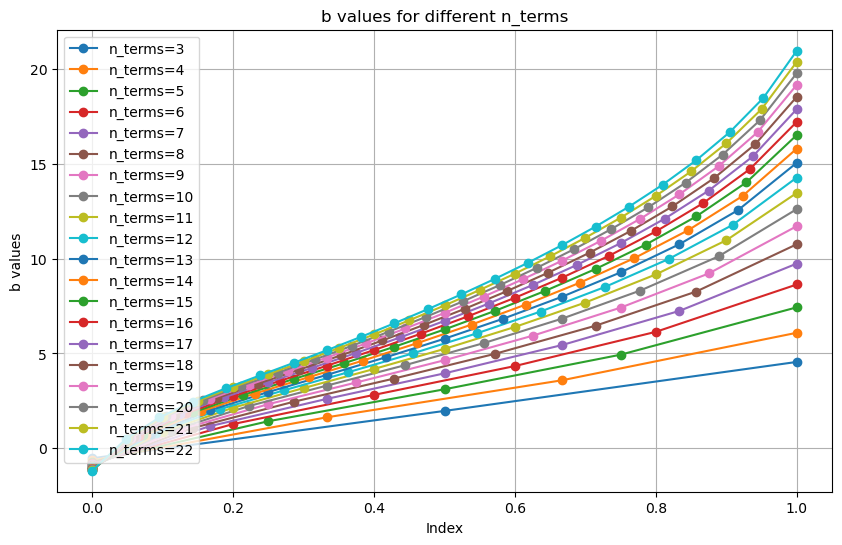

In [333]:
plt.figure(figsize=(10, 6))
for b in all_b:
    n = len(b)
    plt.plot(np.linspace(0,1,n), b, marker='o', label=f'n_terms={n}')
plt.xlabel('Index')
plt.ylabel('b values')
plt.title('b values for different n_terms')
plt.legend()
plt.grid()
plt.show()

In [ ]:
0.048736631729841086
0.009765558517102705
0.0027164645963284485
0.0009224691842598692
0.0003567489211094108
0.00015132960573967146
6.88650323762218e-05
3.3134035904752e-05
1.668510120881157e-05
8.72826707446781e-06
4.716577532812536e-06
2.621357532379115e-06
1.49319282707597e-06
8.693049629847567e-07
5.160444066133435e-07
3.117588586103308e-07
1.9136203804462339e-07
1.1917640036398994e-07
7.521393102102381e-08
4.8053435323769506e-08
3.105059577268505e-08
2.0276045383318623e-08

2.6213575323841613e-06
8.693049629896184e-07
3.1175885860507674e-07
1.1917640037002905e-07
4.805343532011334e-08
2.02760453855524e-08


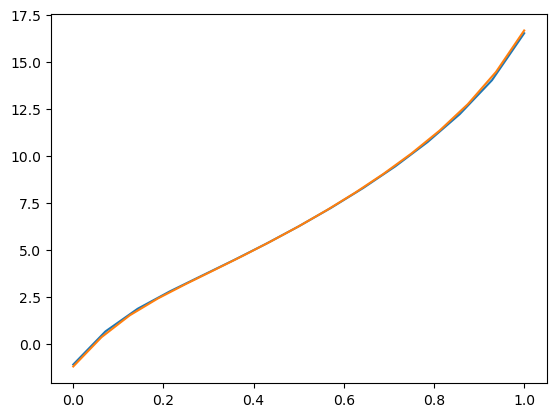

In [246]:
import matplotlib.pyplot as plt
plt.plot(np.linspace(0,1,n_terms),x_vals[n_terms:])
plt.plot(np.linspace(0, 1,n_terms+2),interp_extrap_linear_mid(x_vals[n_terms:], n_terms + 2))

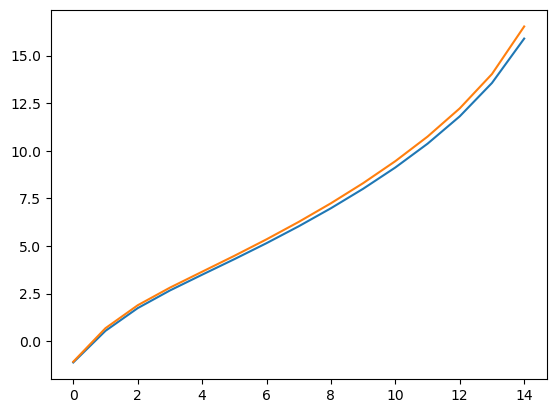

In [245]:
plt.plot(b)
plt.plot(x_vals[n_terms:])

In [7]:
###############################################################################
#  Cross-Entropy search over log-b with internal Newton polishing
###############################################################################
import numpy as np

# --- problem size -----------------------------------------------------------
n_terms = 8          # K  (= length of b and a)
newton_steps = 1     # how many Newton iterations per sample
pop_size = 100       # CE population
np.random.seed(0)    # reproducibility

# --------------------------------------------------------------------------- #
#  helper: CE user-defined update function operating on log-b only
# --------------------------------------------------------------------------- #


def ce_user_fn(b_log_samples: np.ndarray):
    """
    Parameters
    ----------
    b_log_samples : (N, K) ndarray
        Current population in *log* space.
    Returns
    -------
    updated_log_b : (N, K) ndarray
        Polished & sorted log-b that CE will keep using.
    scores        : (N,)  ndarray
        Objective values after polishing (smaller is better).
    info          : dict
        Contains minimum gradient norm among all samples (for CE stopping).
    """
    N, K = b_log_samples.shape
    updated = np.empty_like(b_log_samples)
    scores = np.empty(N)
    grad_norm = np.empty(N)

    for i in range(N):
        # ---- (1) build starting point --------------------------------------
        b_pos = np.exp(b_log_samples[i])            # (K,)  positive
        a_opt = optimal_a(d, w, target, b_pos)      # (K,)
        p0 = np.concatenate([a_opt, b_pos])      # shape (2K,)

        # ---- (2) limited Newton polishing ----------------------------------
        p_new, gnorm, *_ = newton(
            f=obj,
            grad=grad,
            hess=hess,
            x0=p0,
            max_iter=newton_steps,
            tol_grad=1e-6,
            tol_step=1e-6,
            stall_iter=newton_steps,
            ls_bounds=(-2., 2.),
            verbose=False
        )

        if not np.any(np.isnan(p_new)) and not np.any(np.isinf(p_new)) and not np.any(p_new < 0):
            # ---- (3) extract & sort b (log) ------------------------------------
            b_new_pos = np.clip(p_new[K:], 1e-12, None)  # keep positivity
            b_new_log = np.log(b_new_pos)
            order = np.argsort(b_new_log)
            a_opt = optimal_a(d, w, target, b_new_pos)      # (K,)
            p0 = np.concatenate([a_opt, b_new_pos])      # shape (2K,)

            updated[i] = b_new_log[order]
            scores[i] = obj(p0)       # score *after* polishing
            grad_norm[i] = np.linalg.norm(grad(p0))
        else:
            # if polishing failed, keep the original sample
            updated[i] = b_log_samples[i]
            scores[i] = np.inf
            grad_norm[i] = np.inf

    info = {'normg': float(grad_norm.min())}
    return updated, scores, info


# --------------------------------------------------------------------------- #
#  CE initial distribution over log-b
# --------------------------------------------------------------------------- #
init_mean = np.linspace(-1.5, 9.3, n_terms)   # rough guess ⇒ b in ~[0.1, 400]
init_std = np.full(n_terms, 1.0)

# --------------------------------------------------------------------------- #
#  Run Cross-Entropy
# --------------------------------------------------------------------------- #
best_b_log, best_score, ce_info = cross_entropy(
    user_fn=ce_user_fn,
    initial_mean=init_mean,
    initial_std=init_std,
    pop_size=pop_size,
    elite_frac=0.2,
    alpha_mean=0.5,
    alpha_std=0.5,
    n_iters=2000,
    random_state=1234,
    tol_g=1e-6,
    tol_std=1e-6,
    verbose=True      # prints per-iteration progress
)

# --------------------------------------------------------------------------- #
#  Report results
# --------------------------------------------------------------------------- #
best_b = np.exp(best_b_log)
best_a = optimal_a(d, w, target, best_b)
best_obj = obj(np.concatenate([best_a, best_b]))

print("\n====================  CE RESULT  ====================")
print("best log-b :", best_b_log)
print("best b     :", best_b)
print("best a     :", best_a)
print("CE score   :", best_score)
print("check obj  :", best_obj)
print("stopped at iteration", ce_info['iter'],
      "| max σ =", ce_info['max_std_history'][-1])

Iter 0: best_score=0.0013950703793328882, max_std=1.1356440572972426, info={'normg': 0.13175763560330805}
Iter 1: best_score=0.0009889552061308979, max_std=1.2447310414460087, info={'normg': 0.13790330909674978}
Iter 2: best_score=0.0009889552061308979, max_std=1.3869532696309697, info={'normg': 0.07160743968188284}
Iter 3: best_score=0.0009889552061308979, max_std=1.4030271446417653, info={'normg': 0.1294265030283102}
Iter 4: best_score=0.0009889552061308979, max_std=1.3402764583545088, info={'normg': 0.08211164220393306}
Iter 5: best_score=0.0009889552061308979, max_std=1.3223914089623938, info={'normg': 0.08433113742867276}
Iter 6: best_score=0.0009889552061308979, max_std=1.2070336778372304, info={'normg': 0.08518818383235606}
Iter 7: best_score=0.0009889552061308979, max_std=1.1772958148914703, info={'normg': 0.09000993917449461}
Iter 8: best_score=0.0006586318020339291, max_std=1.024109070485738, info={'normg': 0.06882914264805107}
Iter 9: best_score=0.0006586318020339291, max_st

KeyboardInterrupt: 

In [96]:
best_b_log

array([-1.48353019,  0.04141208,  1.34315267,  2.62557281,  4.04747186,
        5.72257207,  7.78431983, 10.25991933])

In [7]:
###############################################################################
#  Differential-Evolution optimiser that works with the same `user_fn`
###############################################################################
from typing import Callable, Tuple, Dict, Any, Optional
import numpy as np


def differential_evolution(
    user_fn: Callable[[np.ndarray],
                      Tuple[np.ndarray, np.ndarray, Dict[str, Any]]],
    initial_mean: np.ndarray,
    initial_std: np.ndarray,
    pop_size: int = 100,
    F: float = 0.8,                 # differential weight
    CR: float = 0.9,                # crossover probability
    n_iters: int = 500,
    random_state: Optional[int] = None,
    tol_g: float = 1e-6,            # stop if min‖g‖ drops below this
    stall_generations: int = 50,    # stop if no improvement for so many gens
    verbose: bool = False
) -> Tuple[np.ndarray, float, Dict[str, Any]]:
    """
    Differential Evolution (DE/rand/1/bin) with the CE-style `user_fn`.

    Returns
    -------
    best_sample : ndarray
        The best parameter vector found (d,).
    best_score  : float
        Objective value of `best_sample`.
    info        : dict
        Diagnostics (`iter`, `best_score_history`).
    """
    rng = np.random.RandomState(random_state)
    d = initial_mean.size

    # --- initial population --------------------------------------------------
    pop = rng.randn(pop_size, d) * initial_std + initial_mean       # (N, d)
    pop, scores, info = user_fn(pop)                               # polish & score
    best_idx = int(np.argmin(scores))
    best_sample = pop[best_idx].copy()
    best_score = float(scores[best_idx])

    best_score_history = [best_score]
    no_improve = 0

    for it in range(1, n_iters + 1):
        # ------------ mutation & crossover ----------------------------------
        trial = np.empty_like(pop)
        for i in range(pop_size):
            # choose three *distinct* indices ≠ i
            r1, r2, r3 = rng.choice([j for j in range(pop_size) if j != i],
                                    size=3, replace=False)
            mutant = pop[r1] + F * (pop[r2] - pop[r3])

            # binomial crossover
            cross_pts = rng.rand(d) < CR
            cross_pts[rng.randint(0, d)] = True      # ensure at least one gene
            trial[i] = np.where(cross_pts, mutant, pop[i])

        # ------------ evaluate trial population ------------------------------
        trial, trial_scores, info_trial = user_fn(trial)

        # ------------ selection ----------------------------------------------
        improved = trial_scores < scores
        pop[improved] = trial[improved]
        scores[improved] = trial_scores[improved]

        # ------------ keep track of best -------------------------------------
        gen_best_idx = int(np.argmin(scores))
        gen_best_score = float(scores[gen_best_idx])
        if gen_best_score + 1e-12 < best_score:      # strict improvement
            best_score = gen_best_score
            best_sample = pop[gen_best_idx].copy()
            no_improve = 0
        else:
            no_improve += 1

        best_score_history.append(best_score)

        if verbose:
            print(f"Gen {it:4d}  best={best_score:.4e} "
                  f"min‖g‖={info_trial.get('normg', np.inf):.2e}")

        # ------------ stopping criteria --------------------------------------
        if info_trial.get('normg', np.inf) <= tol_g:
            if verbose:
                print("Stopping: gradient norm below tol_g")
            break
        if no_improve >= stall_generations:
            if verbose:
                print("Stopping: no improvement for",
                      stall_generations, "generations")
            break

    info = {
        'iter': it,
        'best_score_history': best_score_history
    }
    return best_sample, best_score, info



In [70]:

###############################################################################
#  TEST SCRIPT  —  optimise log-b with the same `ce_user_fn`
###############################################################################

# --- problem & helper already defined earlier ---------------------------
# n_terms, ce_user_fn, d, w, target, obj … are assumed to be in scope

pop_size = 20
rng_seed = 1234

# --- problem size -----------------------------------------------------------
n_terms = 2          # K  (= length of b and a)
newton_steps = 1     # how many Newton iterations per sample
np.random.seed(1)    # reproducibility

# --------------------------------------------------------------------------- #
#  helper: CE user-defined update function operating on log-b only
# --------------------------------------------------------------------------- #
d, w = gauss_legendre_rule_multilevel(0.0, 1.0, 100, L=5, ratio=0.2)
target = np.exp(-d)                  # any reference curve you like

def ce_user_fn(b_log_samples: np.ndarray):
    """
    Parameters
    ----------
    b_log_samples : (N, K) ndarray
        Current population in *log* space.
    Returns
    -------
    updated_log_b : (N, K) ndarray
        Polished & sorted log-b that CE will keep using.
    scores        : (N,)  ndarray
        Objective values after polishing (smaller is better).
    info          : dict
        Contains minimum gradient norm among all samples (for CE stopping).
    """
    N, K = b_log_samples.shape
    updated = np.empty_like(b_log_samples)
    scores = np.empty(N)
    grad_norm = np.empty(N)

    for i in range(N):
        # ---- (1) build starting point --------------------------------------
        b_pos = (b_log_samples[i])            # (K,)  positive
        a_opt = optimal_a(d, w, target, np.exp(b_pos))      # (K,)
        p0 = np.concatenate([a_opt, b_pos])      # shape (2K,)

        # ---- (2) limited Newton polishing ----------------------------------
        p_new, gnorm, *_ = newton(
            f=obj,
            grad=grad,
            hess=hess,
            x0=p0,
            max_iter=newton_steps,
            tol_grad=1e-16,
            tol_step=1e-16,
            stall_iter=newton_steps,
            ls_bounds=(-2.0, 2.),
            verbose=False
        )

        if not np.any(np.isnan(p_new)) and not np.any(np.isinf(p_new)):
            # ---- (3) extract & sort b (log) ------------------------------------
            # b_new_pos = np.clip(p_new[K:], 1e-12, None)  # keep positivity
            b_new_pos = p_new[K:]
            # b_new_log = np.log(b_new_pos)
            b_new_log = b_new_pos
            order = np.argsort(b_new_log)
            a_opt = optimal_a(d, w, target, np.exp(b_new_pos))      # (K,)
            p0 = np.concatenate([a_opt, b_new_pos])      # shape (2K,)

            updated[i] = b_new_log[order]
            scores[i] = np.sqrt(obj(p0))       # score *after* polishing
            grad_norm[i] = np.linalg.norm(grad(p0))
        else:
            # if polishing failed, keep the original sample
            updated[i] = b_log_samples[i]
            scores[i] = np.inf
            grad_norm[i] = np.inf

    min_idx = np.argmin(scores)
    info = {'normg': float(grad_norm[min_idx])}
    return updated, scores, info




init_mean = np.linspace(0,  1, n_terms)   # rough guess ⇒ b in ~[0.1, 400]
init_std = np.full(n_terms, 1.0)

best_b_log, best_score, de_info = differential_evolution(
    user_fn=ce_user_fn,
    initial_mean=init_mean,
    initial_std=init_std,
    pop_size=pop_size,
    F=0.8,
    CR=0.9,
    n_iters=10,
    random_state=rng_seed,
    tol_g=1e-9,
    stall_generations=75,
    verbose=True
)

# --- final reconstruction of a and objective ----------------------------
best_b = np.exp(best_b_log)
best_a = optimal_a(d, w, target, best_b)
best_obj = np.sqrt(obj(np.concatenate([best_a, best_b])))

print("\n====================  DE RESULT  ====================")
print("best log-b :", best_b_log)
print("best b     :", best_b)
print("best a     :", best_a)
print("DE score   :", best_score)
print("check obj  :", best_obj)
print("generations:", de_info['iter'])

Gen    1  best=9.7662e-03 min‖g‖=9.96e-06
Gen    2  best=9.7662e-03 min‖g‖=2.81e-05
Gen    3  best=9.7662e-03 min‖g‖=4.36e-05
Gen    4  best=9.7657e-03 min‖g‖=3.94e-06
Gen    5  best=9.7656e-03 min‖g‖=1.36e-06
Gen    6  best=9.7656e-03 min‖g‖=6.33e-08
Gen    7  best=9.7656e-03 min‖g‖=3.62e-10
Stopping: gradient norm below tol_g

====================  DE RESULT  ====================
best log-b : [-0.34875468  2.6915483 ]
best b     : [ 0.7055662 14.7545027]
best a     : [0.71376705 0.24218186]
DE score   : 0.00976555851710301
check obj  : 0.2119444539178491
generations: 7


In [86]:
newton_steps = 20
pop_size = 4
rng_seed = 123
n_terms = 16
init_mean = np.linspace(min(best_b_log), max(best_b_log), n_terms)   # rough guess ⇒ b in ~[0.1, 400]
init_std = np.full(n_terms, 0.1)

best_b_log, best_score, de_info = differential_evolution(
    user_fn=ce_user_fn,
    initial_mean=init_mean,
    initial_std=init_std,
    pop_size=pop_size,
    F=0.8,
    CR=0.9,
    n_iters=50000,
    random_state=rng_seed,
    tol_g=1e-14,
    stall_generations=750,
    verbose=True
)

# --- final reconstruction of a and objective ----------------------------
best_b = np.exp(best_b_log)
best_a = optimal_a(d, w, target, best_b)
best_obj = obj(np.concatenate([best_a, best_b]))

print("\n====================  DE RESULT  ====================")
print("best log-b :", best_b_log)
print("best b     :", best_b)
print("best a     :", best_a)
print("DE score   :", best_score)
print("check obj  :", best_obj)
print("generations:", de_info['iter'])

Gen    1  best=5.0741e-06 min‖g‖=8.78e-11
Gen    2  best=3.1283e-06 min‖g‖=7.73e-11
Gen    3  best=3.1283e-06 min‖g‖=5.79e-11
Gen    4  best=1.7608e-06 min‖g‖=1.71e-11
Gen    5  best=1.1591e-06 min‖g‖=5.37e-12
Gen    6  best=1.0894e-06 min‖g‖=2.69e-11
Gen    7  best=1.0894e-06 min‖g‖=6.22e-11
Gen    8  best=1.0164e-06 min‖g‖=1.64e-11
Gen    9  best=1.0164e-06 min‖g‖=2.19e-11
Gen   10  best=1.0164e-06 min‖g‖=1.36e-11
Gen   11  best=9.5676e-07 min‖g‖=5.48e-12
Gen   12  best=9.4692e-07 min‖g‖=1.37e-12
Gen   13  best=8.0547e-07 min‖g‖=2.60e-12
Gen   14  best=7.5250e-07 min‖g‖=2.16e-12
Gen   15  best=7.0118e-07 min‖g‖=1.14e-11
Gen   16  best=6.2503e-07 min‖g‖=5.50e-12
Gen   17  best=5.6474e-07 min‖g‖=1.36e-12
Gen   18  best=5.3749e-07 min‖g‖=3.28e-12
Gen   19  best=5.3749e-07 min‖g‖=1.61e-12
Gen   20  best=4.9644e-07 min‖g‖=1.46e-12
Gen   21  best=4.9644e-07 min‖g‖=6.78e-13
Gen   22  best=4.8150e-07 min‖g‖=4.69e-13
Gen   23  best=4.5814e-07 min‖g‖=8.72e-13
Gen   24  best=4.3910e-07 min‖g‖=4

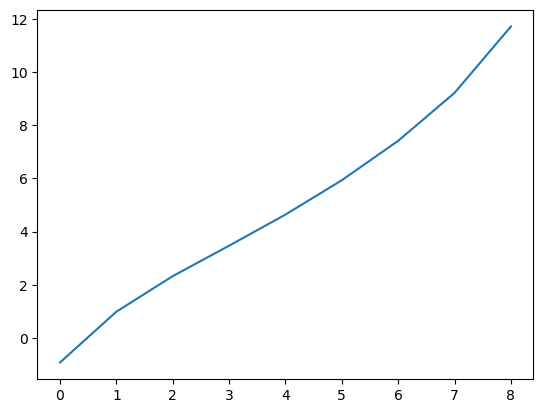

In [64]:
import matplotlib.pyplot as plt
plt.plot(best_b_log)

In [ ]:
g = grad(x)
H = hess(x)
d = np.linalg.solve(H, -g)  # Newton step
dir_obj = lambda alpha: obj(x + alpha * d)
alphas = np.linspace(-1.0, 1.0, 1000)

import matplotlib.pyplot as plt

plt.plot(alphas, [dir_obj(alpha) for alpha in alphas])
plt.xlabel("alpha")
plt.ylabel("Objective along Newton direction")
plt.title("Line search objective along Newton step")
plt.grid()
plt.show()

In [ ]:
N = 500               # data points

d, w = rectangle_rule(0.0, 5.0, N)
target = np.exp(-d)                  # any reference curve you like
f_min_all = []
min_b = -1.0
max_b = 1.5

# --- synthetic data ---------------------------------------------------
for n_terms in range(2, 16):               # number of (a_i, b_i) pairs

    b = np.linspace(min_b * 1.05, max_b * 1.1, n_terms)
    a = optimal_a(d, w, target, np.exp(b))
    # print("Optimal a:", a)

    means = np.concatenate((a, np.exp(b)))  # initial guess in log-space

    # --- optimiser call ---------------------------------------------------
    x, grad_norm, f_history, grad_norm_history = newton(
        f=obj,
        grad=grad,
        hess=hess,
        x0=means,
        tol_grad=1e-5,
        tol_step=1e-8,
        stall_iter=50,
        max_iter=1000,
        ls_bounds=(-2.0, 2.0)
    )
    min_b = min(np.log(x[n_terms:]))
    max_b = max(np.log(x[n_terms:]))
    print(f"Min a log: {min_b}, Max b log: {max_b}")
    print("Final objective value:", f_history[-1])
    f_min_all.append(f_history[-1])

In [ ]:
plt.plot(f_min_all)
plt.yscale('log')

In [ ]:
f_min_all

In [ ]:

# --- synthetic data ---------------------------------------------------

N = 500               # data points

d, w = rectangle_rule(0.0, 2.0, N)
target = np.exp(-d)                  # any reference curve you like
best_init = np.array([0,0])

for n_terms in range(1,10):                 # number of (a_i, b_i) pairs
    means = best_init  # initial mean for (a_i, b_i)
    cov = np.eye(2 * n_terms) * 4  # initial covariance matrix
    # --- optimiser call ---------------------------------------------------
    best, stats = cross_entropy_numba(
        d=d, target=target, w=w,
        n_terms=n_terms,
        max_iter=10000,
        pop_size=10000,
        elite_frac=0.1,
        mean=means,
        cov=cov
    )

    print("Best score :", stats["best_score"])
    print("Best params:", best)
    print("Iterations :", stats["iterations"])
    print("Runtime    :", stats["runtime"], "s")

    first_half = best[:n_terms]
    second_half = best[n_terms:]

    # Original equidistant indices (0 to n_terms-1), new indices from 0 to n_terms
    x_old = np.linspace(0, 1, n_terms)
    x_new = np.linspace(0, 1, n_terms + 1)

    interp_first = np.interp(x_new, x_old, first_half)
    interp_second = np.interp(x_new, x_old, second_half)

    best_init = np.hstack([interp_first, interp_second])

In [ ]:
best_init

In [ ]:
import matplotlib.pyplot as plt
plt.plot(stats["history"])
plt.xlabel("Iteration")
plt.ylabel("Best score")
plt.title("Convergence of the Cross-Entropy Method")
plt.grid()
plt.yscale('log')
plt.show()

In [ ]:
plt.plot(best[n_terms:], 'o-')
plt.xlabel("Index")
plt.ylabel("b_i (log scale)")
plt.title("Fitted b_i parameters")
plt.grid()
plt.show()

In [ ]:
from scipy.optimize import lsq_linear

# compute using least squares the coefficients for approximation with squared exponential kernels
# Construct the design matrix for squared exponential kernels
A = np.zeros((len(d), n_terms))
b_params = np.exp(best[n_terms:])

for i in range(n_terms):
    A[:, i] = np.exp(-b_params[i] * d**2)

# Solve the weighted least squares problem: minimize ||W(Aa - target)||^2
W = np.sqrt(w)
Aw = A * W[:, None]
tw = target * W

res = lsq_linear(Aw, tw, bounds=(0, np.inf))
squared_exponential_coeffs = res.x
print("Squared exponential coefficients:", np.log(squared_exponential_coeffs))

# compute fit with this coefficients
params = np.hstack([np.log(squared_exponential_coeffs), np.log(b_params)])

res = objective_numba(np.array([params]), d, target, w)
print("Objective value with least squares coefficients:", res[0])



In [ ]:
x, w = rectangle_rule(0.0, 2.0, 500)
f = lambda t: np.exp(-t)
a, b, info = fit_exp_sum_ce(5, x, w, f, iterations=2000, pop_size=1000)
print('a:', a)
print('b:', b)
print('best_score:', info.best_score)

In [126]:


n_terms = 10                       # number of (a, b) pairs
p0 = np.concatenate([             # aₖ ~ N(0,1),  log bₖ ~ N(0,1)
    np.exp(np.random.randn(n_terms)), np.linspace(-1.6, 10.5, n_terms)
])
a = optimal_a(x, w, target, np.exp(p0[n_terms:]))  # initial a from target
p0[:n_terms] = a  # replace first n_terms with a

x_opt, f_opt, hist = adam_minimize(obj, grad, p0, lr=1e-2, patience = 1000, decay_factor=0.9,tol=1e-12, verbose=True, print_every=1000, max_iter=1000000)

print("final objective:", f_opt)
print("optimal params :", x_opt)

 iter |     f         |grad|      lr   ------------------------------------------------------------------------------
     1 |  3.4540e-09 |  3.59e-08 |     0.01
  1000 |  3.2200e-09 |  7.84e-08 |     0.01
  1001 | lr decayed → 0.009
  2000 |  1.7077e-07 |  1.13e-03 |    0.009
  2001 | lr decayed → 0.0081
  3000 |  3.2940e-09 |  7.53e-08 |   0.0081
  3001 | lr decayed → 0.00729
  4000 |  3.1850e-09 |  6.06e-08 |  0.00729
  4001 | lr decayed → 0.006561
  5000 |  3.0623e-09 |  5.69e-08 | 0.006561
  5001 | lr decayed → 0.0059049
  6000 |  4.8079e-08 |  5.82e-04 | 0.0059049
  6001 | lr decayed → 0.00531441
  7000 |  2.9543e-09 |  2.67e-07 | 0.00531441
  7001 | lr decayed → 0.00478297
  8000 |  2.8349e-09 |  4.85e-08 | 0.00478297
  8001 | lr decayed → 0.00430467
  9000 |  2.7102e-09 |  4.54e-08 | 0.00430467
  9001 | lr decayed → 0.0038742
 10000 |  3.0491e-08 |  4.57e-04 | 0.0038742
 10001 | lr decayed → 0.00348678
 11000 |  2.5300e-09 |  3.99e-08 | 0.00348678
 11001 | lr decayed → 0.003138